### Анализ новостных статей: как предсказать популярность публикации

**Описание**:

В этом проекте мы проанализировали статьи с сайта РИА Новости, чтобы выяснить, какие факторы влияют на количество просмотров. Мы собрали и обработали данные, выполнили EDA, построили визуализации и простую модель для предсказания успешности статьи.

In [9]:

import ast
import json
from collections import Counter
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import spacy
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

from scripts.parser import parse_category


# Загрузка данных

Парсинг данных реализован в `scripts/parser.py` на Selenium. Но запуск и управление парсером осуществляется ниже.

Для исследования использовались последние 200 статей с каждой категории: "Политика", "В мире", "Экономика",
"Общество", "Происшествия", "Армия", что в сумме дает чуть меньше 1200 уникальных записей.

Количество искомых статей можно изменять в переменной `max_articles`.

In [ ]:
# Список категорий для сбора
CATEGORIES = {
    "Политика": "https://ria.ru/politics/",
    "В мире": "https://ria.ru/world/",
    "Экономика": "https://ria.ru/economy/",
    "Общество": "https://ria.ru/society/",
    "Происшествия": "https://ria.ru/incidents/",
    "Армия": "https://ria.ru/defense_safety/"
}

# Папка для сохранения результатов
output_dir = Path("data/raw")
output_dir.mkdir(parents=True, exist_ok=True)

# Основной словарь результатов
all_data = {}

# Определим, какое число статей хотим собрать с категории
# Статьи собираются от новых к старым
max_articles=200

# Сбор по всем категориям
for category, url in CATEGORIES.items():
    print(f"\nСобираем данные из категории: {category}")
    articles = parse_category(url, max_articles)
    all_data[category] = articles

# Сохранение в файл
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = output_dir / f"ria_news_{timestamp}.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(all_data, f, ensure_ascii=False, indent=2)

print(f"\nГотово. Сохранено в файл: {output_path}")


## Очистка данных и подготовка к анализу

In [10]:
# Загрузка моделей и ресурсов
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
nlp = spacy.load("ru_core_news_sm")

# Путь к последнему JSON-файлу с данными
raw_data_dir = Path("data/raw")
json_files = sorted(raw_data_dir.glob("ria_news_*.json"), reverse=True)
latest_file = json_files[0] if json_files else None

if not latest_file:
    raise FileNotFoundError("Нет доступных JSON-файлов в data/raw")

print(f"Загружается файл: {latest_file.name}")

# Загрузка JSON
with open(latest_file, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

# Преобразование в плоский DataFrame
rows = []
for category, articles in raw_data.items():
    for url, content in articles.items():
        tags = content.get("tags") if content.get("tags") else []
        tags = [t for t in tags if t.strip() != ""]
        rows.append({
            "category": category,
            "url": url,
            "title": content.get("title"),
            "views": content.get("views"),
            "tags": tags
        })

df = pd.DataFrame(rows)
print(f"Всего записей: {len(df)}")

# Очистка данных
df.dropna(subset=["title", "views"], inplace=True)
df.drop_duplicates(subset="url", inplace=True)
df["title"] = df["title"].str.strip().str.lower()
df["views"] = pd.to_numeric(df["views"], errors="coerce")
df["tags"] = df["tags"].apply(lambda tags: [t for t in tags if t.strip()])

# --- Обработка текста ---
def preprocess_title(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if token.is_alpha]
    tokens_no_stop = [t for t in tokens if t.lower() not in stop_words]
    lemmas = [token.lemma_ for token in doc if token.is_alpha and token.lemma_.lower() not in stop_words]
    ents = [(ent.text, ent.label_) for ent in doc.ents]
    return {
        "clean": " ".join(tokens_no_stop),
        "tokens": tokens_no_stop,
        "lemmas": lemmas,
        "entities": ents
    }

processed = df["title"].apply(preprocess_title)
df["title_clean"] = processed.map(lambda x: x["clean"])
df["title_tokens"] = processed.map(lambda x: x["tokens"])
df["title_lemmas"] = processed.map(lambda x: x["lemmas"])
df["named_entities"] = processed.map(lambda x: x["entities"])


# Сохраняем чистые данные
output_path = Path("data/processed")
output_path.mkdir(parents=True, exist_ok=True)
clean_file = output_path / "clean_articles.csv"
df.to_csv(clean_file, index=False, encoding="utf-8")

print(f"Готово. Сохранено в: {clean_file}")
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maitre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[2025-04-29 22:00:26] INFO - Loading dictionaries from C:\Users\maitre\miniconda3\Lib\site-packages\pymorphy3_dicts_ru\data
[2025-04-29 22:00:26] INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962


Загружается файл: ria_news_20250429_164325.json
Всего записей: 1200
Готово. Сохранено в: data\processed\clean_articles.csv


,category,url,title,views,tags,title_clean,title_tokens,title_lemmas,named_entities
0,Политика,https://rsport.ria.ru/20250429/stupak-20141064...,вяльбе поддержала участие ступак в партийных в...,25,"[Политика, Лыжные гонки, Республика Коми, Сосн...",вяльбе поддержала участие ступак партийных выб...,"[вяльбе, поддержала, участие, ступак, партийны...","[вяльбе, поддержать, участие, ступак, партийны...","[(вяльбе, PER)]"
1,Политика,https://ria.ru/20250429/putin-2014072360.html,путин прилетел в волгоград,1825,"[Политика, Волгоград, Россия, Владимир Путин, ...",путин прилетел волгоград,"[путин, прилетел, волгоград]","[путин, прилететь, волгоград]","[(путин, PER), (волгоград, LOC)]"
2,Политика,https://ria.ru/20250429/volodin-2014019151.html,володин назвал защиту исторической правды одни...,263,"[Политика, Белоруссия, Волгоград, Владимир Путин]",володин назвал защиту исторической правды одни...,"[володин, назвал, защиту, исторической, правды...","[володин, назвать, защита, исторический, правд...","[(володин, PER), (сг, ORG)]"
3,Политика,https://ria.ru/20250429/peskov-2014002713.html,песков высказался о легитимности зеленского на...,9770,"[Политика, Россия, Дмитрий Песков, Владимир Зе...",песков высказался легитимности зеленского пост...,"[песков, высказался, легитимности, зеленского,...","[песков, высказаться, легитимность, зеленского...","[(песков, PER)]"
4,Политика,https://ria.ru/20250429/klishas-2013972100.html,сенатор клишас шуткой отреагировал на слова во...,11183,"[Политика, Госдума РФ, Андрей Клишас, Вячеслав...",сенатор клишас шуткой отреагировал слова волод...,"[сенатор, клишас, шуткой, отреагировал, слова,...","[сенатор, клишас, шутка, отреагировать, слово,...","[(клишас шуткой, PER)]"


In [11]:
# Загрузка обработанных данных
data_path = Path("data/processed/clean_articles.csv")
df = pd.read_csv(data_path)

# Выводим сводную таблицу с количеством строк, типами и непустыми значениями
summary = pd.DataFrame({
    'Тип данных': df.dtypes,
    'Количество значений': df.count(),
    'Пропусков': df.isna().sum()
})
print("📋 Обзор структуры таблицы:")
display(summary)

# Покажем первые строки таблицы с ограничением по ширине столбцов
with pd.option_context('display.max_colwidth', 80):
    display(df.head(5))

📋 Обзор структуры таблицы:


,Тип данных,Количество значений,Пропусков
category,object,1188,0
url,object,1188,0
title,object,1188,0
views,int64,1188,0
tags,object,1188,0
title_clean,object,1188,0
title_tokens,object,1188,0
title_lemmas,object,1188,0
named_entities,object,1188,0


,category,url,title,views,tags,title_clean,title_tokens,title_lemmas,named_entities
0,Политика,https://rsport.ria.ru/20250429/stupak-2014106405.html,вяльбе поддержала участие ступак в партийных выборах,25,"['Политика', 'Лыжные гонки', 'Республика Коми', 'Сосногорск (район)']",вяльбе поддержала участие ступак партийных выборах,"['вяльбе', 'поддержала', 'участие', 'ступак', 'партийных', 'выборах']","['вяльбе', 'поддержать', 'участие', 'ступак', 'партийный', 'выбор']","[('вяльбе', 'PER')]"
1,Политика,https://ria.ru/20250429/putin-2014072360.html,путин прилетел в волгоград,1825,"['Политика', 'Волгоград', 'Россия', 'Владимир Путин', 'Александр Лукашенко']",путин прилетел волгоград,"['путин', 'прилетел', 'волгоград']","['путин', 'прилететь', 'волгоград']","[('путин', 'PER'), ('волгоград', 'LOC')]"
2,Политика,https://ria.ru/20250429/volodin-2014019151.html,володин назвал защиту исторической правды одним из приоритетов сг,263,"['Политика', 'Белоруссия', 'Волгоград', 'Владимир Путин']",володин назвал защиту исторической правды одним приоритетов сг,"['володин', 'назвал', 'защиту', 'исторической', 'правды', 'одним', 'приорите...","['володин', 'назвать', 'защита', 'исторический', 'правда', 'одним', 'приорит...","[('володин', 'PER'), ('сг', 'ORG')]"
3,Политика,https://ria.ru/20250429/peskov-2014002713.html,песков высказался о легитимности зеленского на посту президента,9770,"['Политика', 'Россия', 'Дмитрий Песков', 'Владимир Зеленский', 'Украина']",песков высказался легитимности зеленского посту президента,"['песков', 'высказался', 'легитимности', 'зеленского', 'посту', 'президента']","['песков', 'высказаться', 'легитимность', 'зеленского', 'пост', 'президент']","[('песков', 'PER')]"
4,Политика,https://ria.ru/20250429/klishas-2013972100.html,сенатор клишас шуткой отреагировал на слова володина о нем,11183,"['Политика', 'Госдума РФ', 'Андрей Клишас', 'Вячеслав Володин']",сенатор клишас шуткой отреагировал слова володина нем,"['сенатор', 'клишас', 'шуткой', 'отреагировал', 'слова', 'володина', 'нем']","['сенатор', 'клишас', 'шутка', 'отреагировать', 'слово', 'володин', 'нем']","[('клишас шуткой', 'PER')]"


In [12]:
# Преобразуем строковые представления списков тегов обратно в списки
if df["tags"].apply(type).eq(str).any():
    df["tags"] = df["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

print(f"Загружено записей: {len(df)}")
df.head()

Загружено записей: 1188


,category,url,title,views,tags,title_clean,title_tokens,title_lemmas,named_entities
0,Политика,https://rsport.ria.ru/20250429/stupak-20141064...,вяльбе поддержала участие ступак в партийных в...,25,"[Политика, Лыжные гонки, Республика Коми, Сосн...",вяльбе поддержала участие ступак партийных выб...,"['вяльбе', 'поддержала', 'участие', 'ступак', ...","['вяльбе', 'поддержать', 'участие', 'ступак', ...","[('вяльбе', 'PER')]"
1,Политика,https://ria.ru/20250429/putin-2014072360.html,путин прилетел в волгоград,1825,"[Политика, Волгоград, Россия, Владимир Путин, ...",путин прилетел волгоград,"['путин', 'прилетел', 'волгоград']","['путин', 'прилететь', 'волгоград']","[('путин', 'PER'), ('волгоград', 'LOC')]"
2,Политика,https://ria.ru/20250429/volodin-2014019151.html,володин назвал защиту исторической правды одни...,263,"[Политика, Белоруссия, Волгоград, Владимир Путин]",володин назвал защиту исторической правды одни...,"['володин', 'назвал', 'защиту', 'исторической'...","['володин', 'назвать', 'защита', 'исторический...","[('володин', 'PER'), ('сг', 'ORG')]"
3,Политика,https://ria.ru/20250429/peskov-2014002713.html,песков высказался о легитимности зеленского на...,9770,"[Политика, Россия, Дмитрий Песков, Владимир Зе...",песков высказался легитимности зеленского пост...,"['песков', 'высказался', 'легитимности', 'зеле...","['песков', 'высказаться', 'легитимность', 'зел...","[('песков', 'PER')]"
4,Политика,https://ria.ru/20250429/klishas-2013972100.html,сенатор клишас шуткой отреагировал на слова во...,11183,"[Политика, Госдума РФ, Андрей Клишас, Вячеслав...",сенатор клишас шуткой отреагировал слова волод...,"['сенатор', 'клишас', 'шуткой', 'отреагировал'...","['сенатор', 'клишас', 'шутка', 'отреагировать'...","[('клишас шуткой', 'PER')]"


## Анализ и визуализация

### 1. Распределение просмотров (логарифмическая шкала)
Мы начинаем с изучения того, как распределяются просмотры у всех новостных статей.
Это важно, чтобы понять, есть ли выбросы (очень популярные статьи), смещённость распределения и стоит ли применять логарифмическую шкалу для дальнейшего анализа.

На практике выяснилось, что распределение **сильно смещено**: большинство статей набирают очень мало просмотров, а единичные публикации — миллионы. Поэтому мы используем логарифмическую шкалу, чтобы визуализировать основные закономерности и увидеть форму распределения более наглядно.

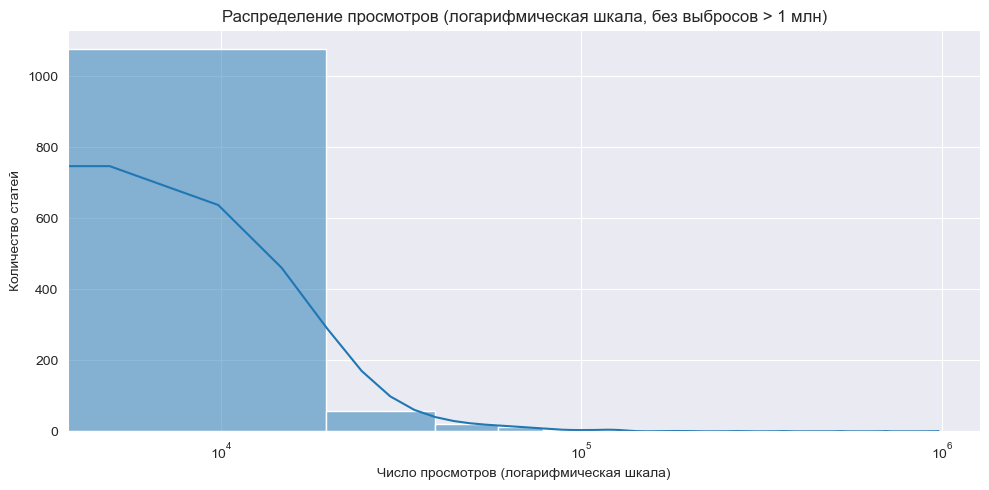

In [32]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df["views"] < 1_000_000]["views"], bins=50, kde=True)
plt.xscale("log")
plt.title("Распределение просмотров (логарифмическая шкала, без выбросов > 1 млн)")
plt.xlabel("Число просмотров (логарифмическая шкала)")
plt.ylabel("Количество статей")
plt.tight_layout()
plt.show()

### 2. Boxplot просмотров по категориям
Далее мы хотим понять, есть ли категории, которые в среднем получают больше просмотров. Boxplot — идеальный инструмент для этого: он показывает медиану, границы квартилей и выбросы.

Сравнив распределения, мы видим, что хотя большинство категорий имеют похожую медиану, в каждой из них встречаются
статьи с аномально высокими просмотрами. Это говорит о том, что успешность статьи зависит не столько от тематики,
сколько от содержания и контекста публикации. А категория "Общество" имеет самые высокие выбросы. Это единичные
случаи, которые не несут статистической ценности, но могут быть интересны в качестве отдельных кейсов.

Этот график позволяет сравнить распределение просмотров по категориям.


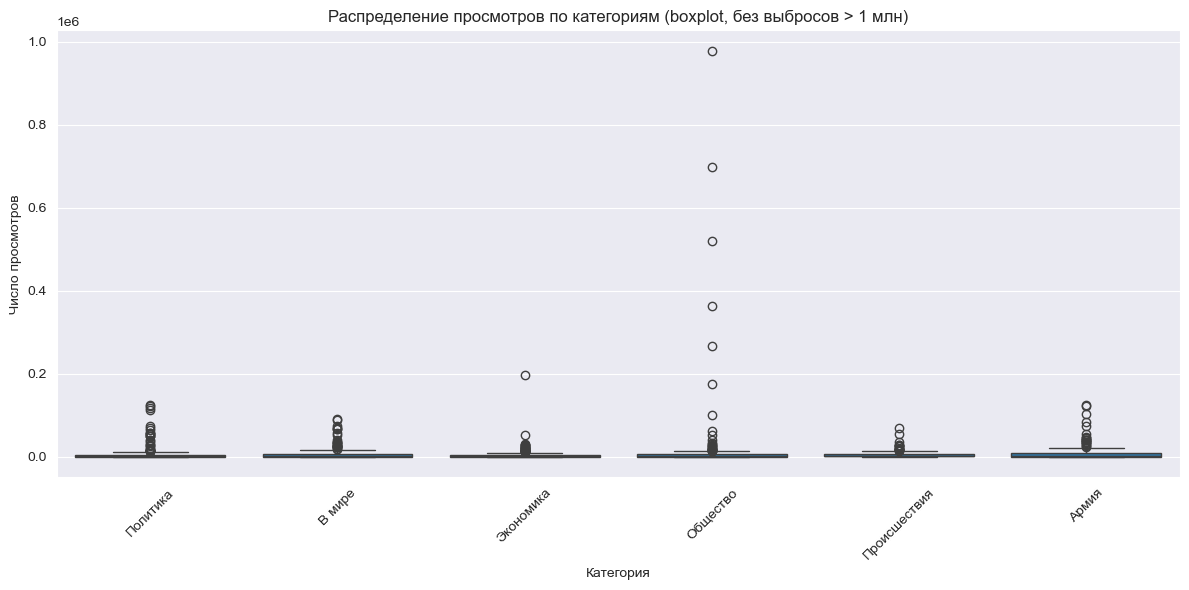

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="category", y="views", data=df[df["views"] < 1_000_000])
plt.xticks(rotation=45)
plt.title("Распределение просмотров по категориям (boxplot, без выбросов > 1 млн)")
plt.xlabel("Категория")
plt.ylabel("Число просмотров")
plt.tight_layout()
plt.show()

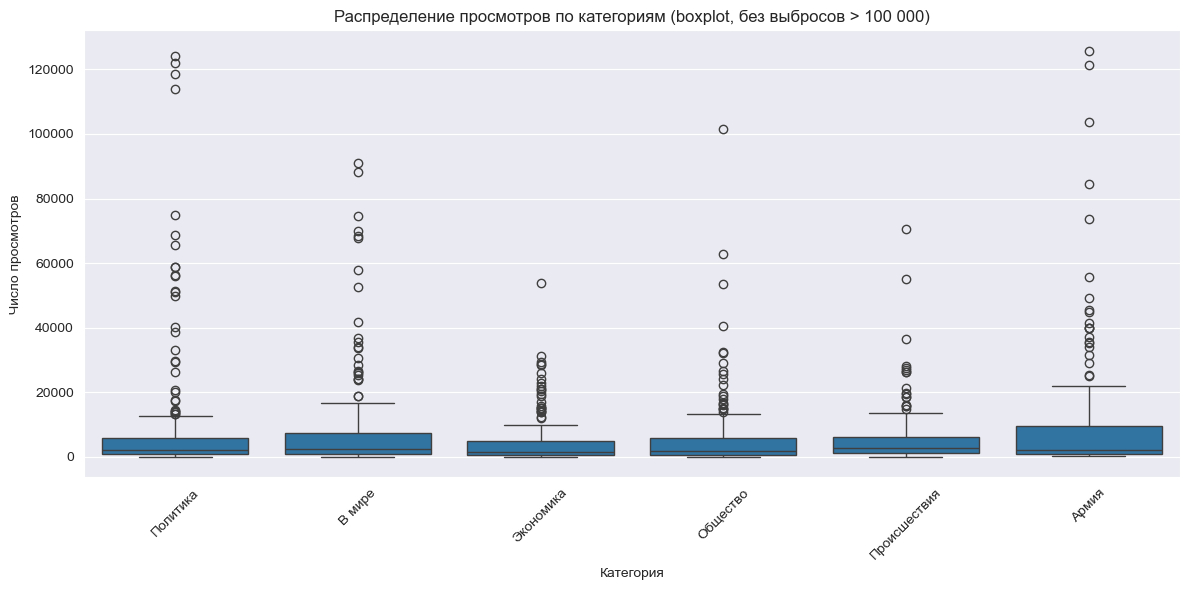

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="category", y="views", data=df[df["views"] < 150_000])
plt.xticks(rotation=45)
plt.title("Распределение просмотров по категориям (boxplot, без выбросов > 150 000)")
plt.xlabel("Категория")
plt.ylabel("Число просмотров")
plt.tight_layout()
plt.show()

### 3. Топ-10 статей по просмотрам
Этот блок позволяет быстро оценить, какие статьи стали самыми успешными на платформе. Мы выводим таблицу с 10 наиболее просматриваемыми статьями и анализируем их темы. Это помогает выявить, какие темы, заголовки и категории вызывают наибольший интерес у аудитории.

In [15]:
top10 = df.sort_values(by="views", ascending=False).head(10)
print("Топ-10 самых просматриваемых статей:")
top10[["category", "title", "views"]]

Топ-10 самых просматриваемых статей:


,category,title,views
655,Общество,что такое ретроградный меркурий и как он влияе...,7817121
611,Общество,как отдыхаем в мае 2025 года: праздники и пере...,5501491
254,В мире,родительские субботы в 2025 году: расписание и...,3058172
657,Общество,банкротство физических лиц в 2025 году: порядо...,1151357
656,Общество,как встать на биржу труда в 2025 году: пошагов...,978061
605,Общество,расписание егэ в 2025-м: даты проведения экзам...,698899
695,Общество,"магнитные бури сегодня: причины, влияние на зд...",518856
735,Общество,как отдыхаем в июне 2025: производственный кал...,364415
600,Общество,"радоница в 2025 году: когда будет, история пра...",268273
485,Экономика,"ключевая ставка цб рф: для чего нужна, почему ...",196200


### 4. Частотность слов (лемм) в заголовках
Заголовки новостей играют ключевую роль в привлечении внимания читателя. Мы провели анализ самых часто встречающихся слов (в форме лемм) в заголовках всех статей. Это помогает понять, какие темы, имена и события чаще всего поднимаются на сайте.

Как видно по результатам, доминируют леммы, связанные с Россией, политикой, событиями и лицами, активно фигурирующими в общественной повестке. Такие слова можно использовать как основу для ключевых тем или трендов.

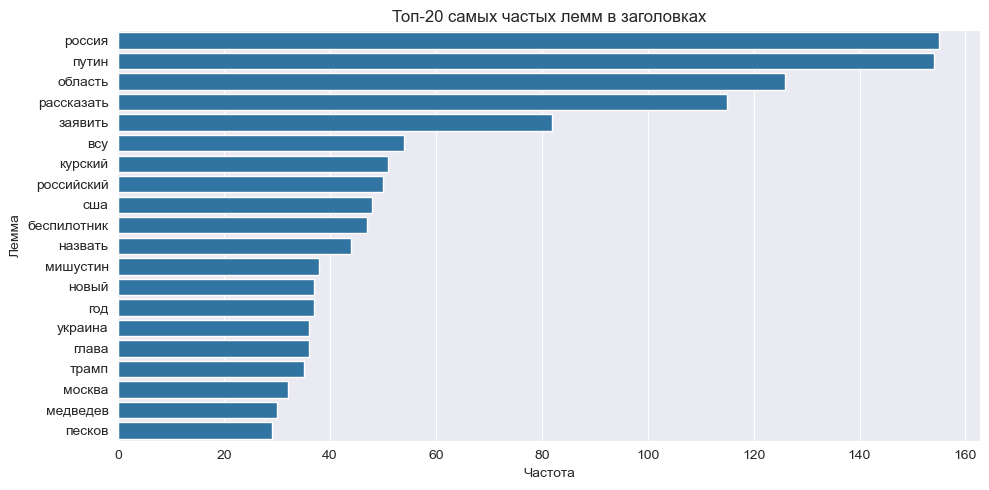

In [16]:
all_lemmas = df["title_lemmas"].dropna().apply(eval).sum()
lemma_freq = Counter(all_lemmas)
top_lemmas = pd.DataFrame(lemma_freq.most_common(20), columns=["Лемма", "Частота"])

plt.figure(figsize=(10, 5))
sns.barplot(data=top_lemmas, x="Частота", y="Лемма")
plt.title("Топ-20 самых частых лемм в заголовках")
plt.xlabel("Частота")
plt.ylabel("Лемма")
plt.tight_layout()
plt.show()

## 5. Частотность тегов и их связь с просмотрами
Теги помогают понять, к каким темам и событиям относится каждая статья. Мы подсчитали, какие теги встречаются чаще всего и насколько они коррелируют с числом просмотров.

Результаты показывают, что наибольшую популярность набирают статьи с тегами, связанными с "Россия", "Общество", "Безопасность", а также упоминающими конкретных политических лидеров. Это указывает на важность персоналий и чувствительных тем в привлечении внимания аудитории.

Загружено записей: 1188


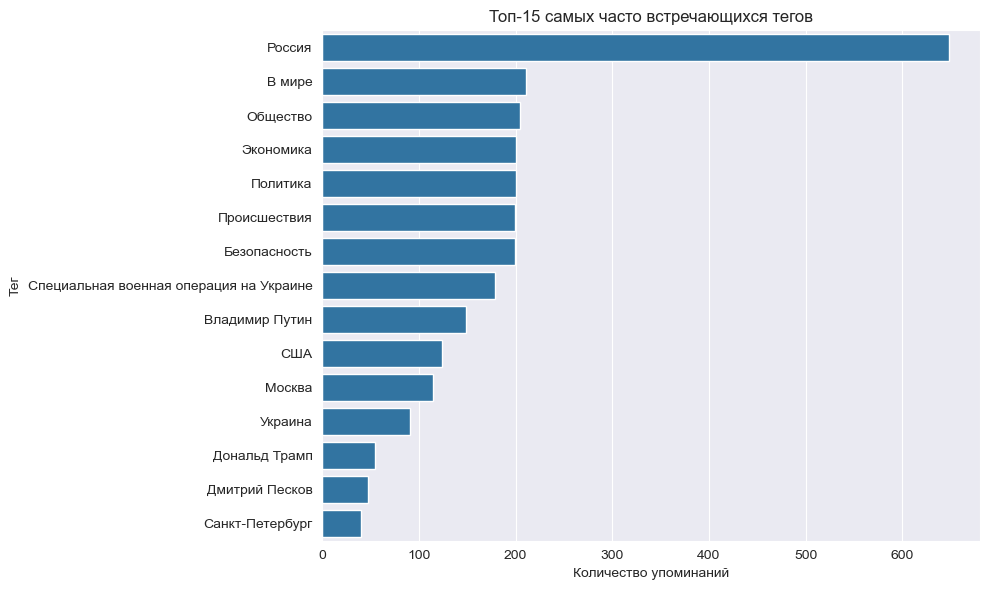

In [17]:
# Преобразуем строковые представления списков тегов обратно в списки
if df["tags"].apply(type).eq(str).any():
    df["tags"] = df["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

print(f"Загружено записей: {len(df)}")
df.head()

tags_expanded = df.explode("tags")
tag_stats = tags_expanded.groupby("tags")["views"].agg(["count", "mean"]).sort_values("count", ascending=False)

# Выведем топ-15 самых часто встречающихся тегов
top_tags = tag_stats.head(15).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_tags, x="count", y="tags")
plt.title("Топ-15 самых часто встречающихся тегов")
plt.xlabel("Количество упоминаний")
plt.ylabel("Тег")
plt.tight_layout()
plt.show()

### 6. Частотность упоминаний именованных сущностей (NER)
Этот анализ извлекает и считает наиболее часто упоминаемые именованные сущности в заголовках — то есть:
- имена людей (PER),
- страны, регионы, города (LOC/GPE),
- организации (ORG) и др.

Сущности определяются заранее обученной моделью spaCy и отображаются на графике по убыванию частоты.

Из графика видно:
- На первом месте — "Путин" и "Россия":
    - Президент России — центральная персона всех новостей, что естественно для госагентства.
    - Частое упоминание страны — логично для национального ресурса.
- "ВСУ", "США", "Курской области", "Песков", "Мишустин":
    - Сильное внимание к теме конфликта с Украиной;
    - Региональные и военные сущности занимают важное место;
    - Пресс-секретарь президента и премьер-министр часто упоминаются как официальные источники или спикеры.
- Иностранные фигуры и государства:
    - "Трамп", "Испании", "США" — указывают на интерес к международной повестке.
- Много упоминаний военных и политических структур:
    - "ВС", "ВВО", "Кремле", "СМИ" — статьи касаются не только лиц, но и институтов власти.



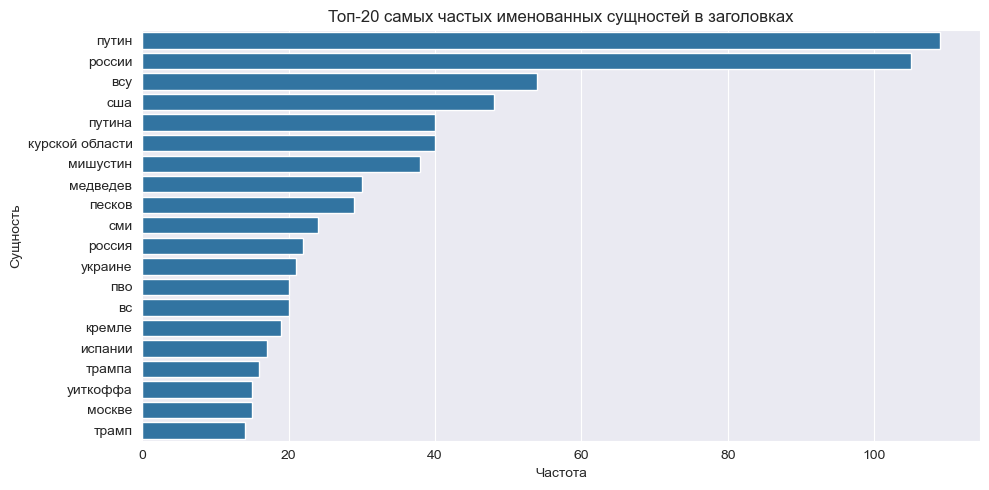

In [18]:
if "named_entities" in df.columns:
    all_ents = df["named_entities"].dropna().apply(eval).sum()
    ent_texts = [ent[0] for ent in all_ents]
    ent_freq = Counter(ent_texts)
    top_ents = pd.DataFrame(ent_freq.most_common(20), columns=["Сущность", "Частота"])

    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_ents, x="Частота", y="Сущность")
    plt.title("Топ-20 самых частых именованных сущностей в заголовках")
    plt.xlabel("Частота")
    plt.ylabel("Сущность")
    plt.tight_layout()
    plt.show()


### 7. Сравнение популярных и непопулярных статей по леммам
Этот анализ:
- Делит статьи на две группы: топ‑10% по просмотрам и остальные 90%;
- Считает, какие леммы чаще встречаются в заголовках популярных статей;
- Вычисляет относительную разницу частот, чтобы выявить слова, характерные для "успешных" публикаций.

```Разница = (упоминания в топ-10% − в остальных 90%) / (сумма упоминаний в обеих группах)```

Как читать график:
- По оси Y — леммы (слова в начальной форме).
- По оси X — относительная частота:
- Леммы со значением > 0 — чаще в популярных.
- Леммы со значением < 0 — чаще в непопулярных.

Что показывает результат:
- Чаще встречаются в популярных заголовках:
    - "зеленского", "заявление", "киев", "фсб", "праздник":
        - Акцент на конфликтных темах, официальных высказываниях, геополитике.
- Чаще встречаются в непопулярных:
    - "терракт", "вс", "сми", "освобождение":
    - Вероятно, темы, которые подаются часто, но реже привлекают внимание в заголовке;
    - Возможно — дежурные, повторяющиеся формулировки.

Почему слово "терракт" оказалось малохарактерным для популярных статей?
На графике, сравнивающем частоту лемм в популярных и непопулярных заголовках, слово **"терракт"** неожиданно оказалось **ниже нуля**, то есть **чаще встречается в заголовках непопулярных статей**.

Хотя тема терактов потенциально громкая и чувствительная, это не делает её автоматически «виральной». Ниже представлены возможные причины этого наблюдения:
- **Сухая или нейтральная подача**: заголовки с этим словом часто формулируются официально и не содержат эмоционального или провокационного контекста. Это снижает вероятность клика.

- **Не факт, а угроза**: упоминание "теракта" может касаться его предотвращения или подозрения, а не самого события. Такие статьи воспринимаются как «дежурные» и вызывают меньше интереса.

- **Эмоциональное выгорание аудитории**: в условиях постоянного новостного фона, связанного с конфликтами и опасностями, пользователь может быть менее чувствителен к тревожным темам.

- **Ограничения в продвижении**: алгоритмы социальных сетей и новостных агрегаторов могут понижать охват публикаций с такими терминами, чтобы снизить дестабилизирующее воздействие.


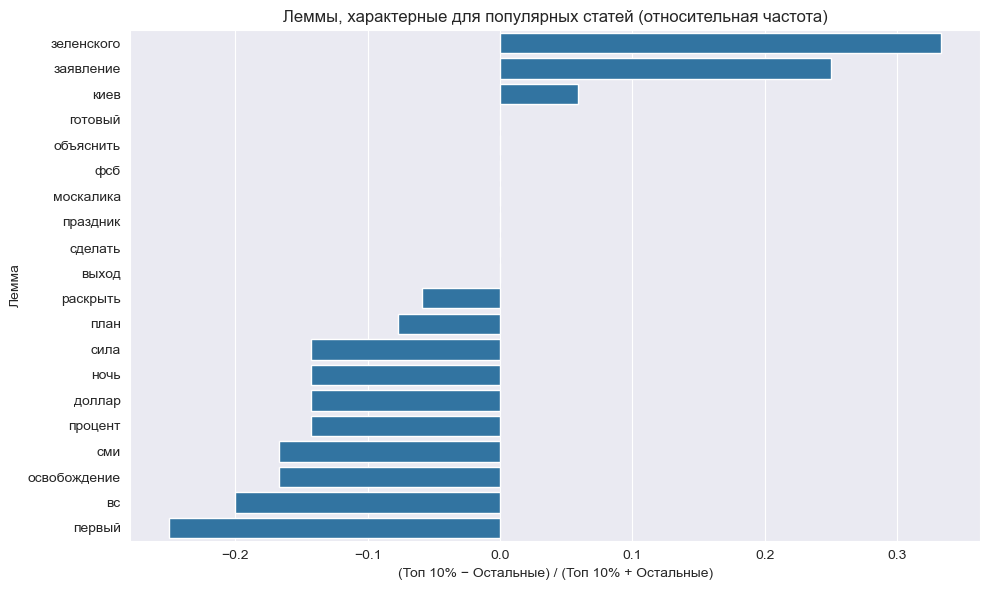

In [19]:
# Разделим статьи на 2 группы: верхние 10% по просмотрам и нижние 90%
thresh = df["views"].quantile(0.85)
df["popularity"] = df["views"].apply(lambda x: "Топ 10%" if x >= thresh else "Остальные")

# Подсчитаем частоты лемм в каждой группе
def get_lemma_freq(subset):
    return Counter(subset["title_lemmas"].dropna().apply(eval).sum())

freq_top = get_lemma_freq(df[df["popularity"] == "Топ 10%"])
freq_rest = get_lemma_freq(df[df["popularity"] == "Остальные"])

# Вычислим относительную разницу: (freq_top - freq_rest) / (freq_top + freq_rest)
lemmas_common = set(freq_top) & set(freq_rest)
lemma_diff = [
    (lemma, freq_top[lemma], freq_rest[lemma], (freq_top[lemma] - freq_rest[lemma]) / (freq_top[lemma] + freq_rest[lemma]))
    for lemma in lemmas_common if freq_top[lemma] + freq_rest[lemma] > 5
]

lemma_diff_df = pd.DataFrame(lemma_diff, columns=["Лемма", "В топ-10%", "В остальных", "Относительная разница"])
lemma_diff_df = lemma_diff_df.sort_values("Относительная разница", ascending=False).head(20)

# График слов, характерных для популярных статей
plt.figure(figsize=(10, 6))
sns.barplot(data=lemma_diff_df, x="Относительная разница", y="Лемма")
plt.title("Леммы, характерные для популярных статей (относительная частота)")
plt.xlabel("(Топ 10% − Остальные) / (Топ 10% + Остальные)")
plt.ylabel("Лемма")
plt.tight_layout()
plt.show()


### 8. Корреляции признаков с числом просмотров
Этот блок помогает выяснить, **есть ли статистическая связь между характеристиками статьи и её популярностью** (количеством просмотров).

Мы анализируем три числовых признака:
- Число тегов в статье (`num_tags`)
- Количество слов в заголовке (`num_words`)
- Количество именованных сущностей (`num_entities`)

#### Корреляционная матрица (heatmap)

На тепловой карте видно, что:
- **Ни один признак не демонстрирует сильной линейной связи** с количеством просмотров;
- Максимальная корреляция наблюдается у `num_tags` и `views` — всего **0.07**, что считается **очень слабой** положительной связью;
- `num_entities` и `num_words` вообще имеют отрицательную корреляцию с `views`.

**Вывод**: эти признаки, взятые по отдельности, **не объясняют популярность статей**.

#### Диаграммы рассеяния (scatter plots)

На графиках рассеяния видно, что:
- **Облака точек хаотичны** — никакой явной линейной зависимости;
- Даже статьи с одинаковым числом тегов или сущностей могут иметь **радикально разное количество просмотров**;
- Это ещё раз подтверждает: **признаки сами по себе не определяют успех статьи**.

---

**Что это значит?**
- Популярность новостей зависит не от количества тегов, слов или упомянутых сущностей, а **от содержания, темы, стиля подачи или других контекстуальных факторов**;
- Для более точного предсказания нужно использовать **семантические признаки**, контент статьи или тематическое моделирование.



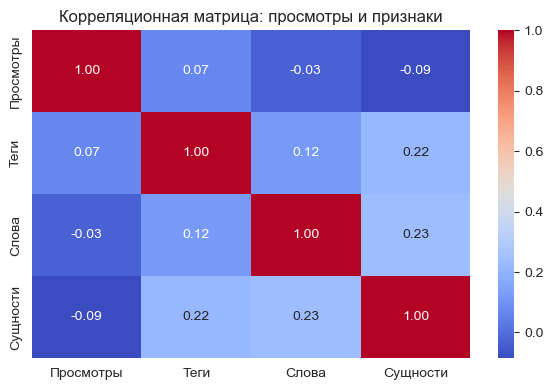

In [20]:
# Число тегов, слов в заголовке и сущностей
if df["tags"].apply(type).eq(str).any():
    df["tags"] = df["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

if "title_tokens" in df.columns and df["title_tokens"].apply(type).eq(str).any():
    df["title_tokens"] = df["title_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

if "named_entities" in df.columns and df["named_entities"].apply(type).eq(str).any():
    df["named_entities"] = df["named_entities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Добавим числовые признаки
df["num_tags"] = df["tags"].apply(lambda x: len(x) if isinstance(x, list) else 0)
df["num_words"] = df["title_tokens"].apply(lambda x: len(x) if isinstance(x, list) else 0)
df["num_entities"] = df["named_entities"].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Вычислим корреляции
corr_df = df[["views", "num_tags", "num_words", "num_entities"]].corr()
corr_df.index = ["Просмотры", "Теги", "Слова", "Сущности"]
corr_df.columns = ["Просмотры", "Теги", "Слова", "Сущности"]

plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица: просмотры и признаки")
plt.tight_layout()
plt.show()

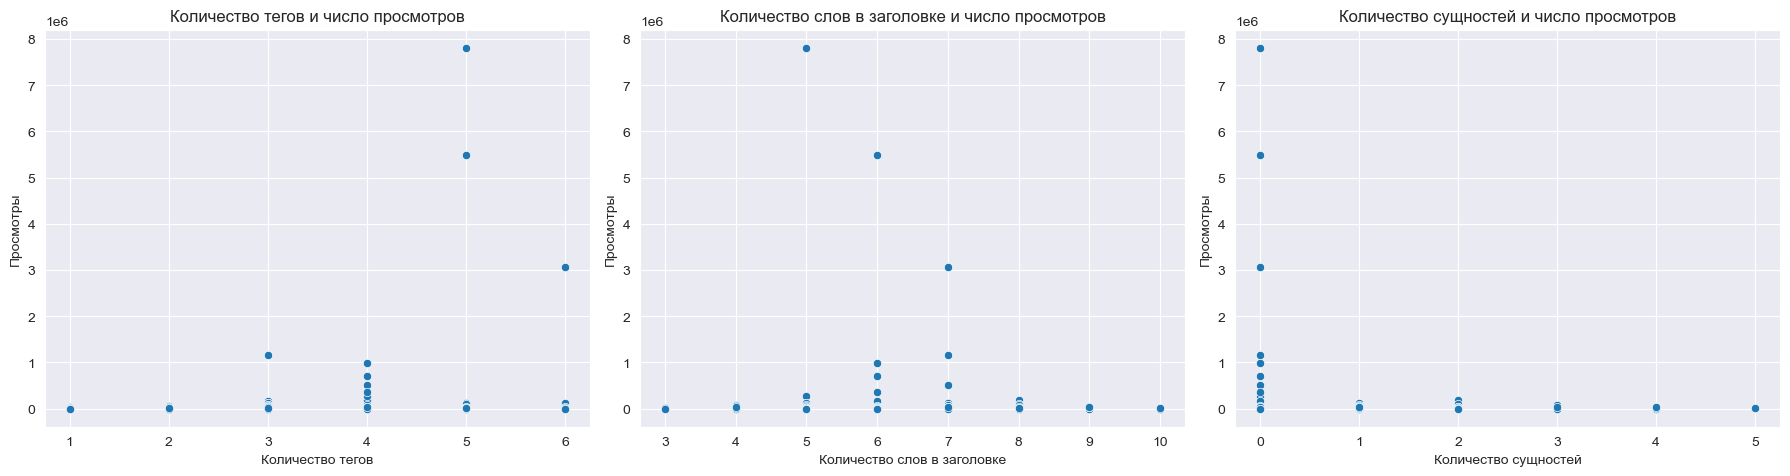

In [21]:
# Дополнительно: диаграммы рассеяния
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(data=df, x="num_tags", y="views", ax=axs[0])
axs[0].set_title("Количество тегов и число просмотров")
axs[0].set_xlabel("Количество тегов")
axs[0].set_ylabel("Просмотры")
sns.scatterplot(data=df, x="num_words", y="views", ax=axs[1])
axs[1].set_title("Количество слов в заголовке и число просмотров")
axs[1].set_xlabel("Количество слов в заголовке")
axs[1].set_ylabel("Просмотры")
sns.scatterplot(data=df, x="num_entities", y="views", ax=axs[2])
axs[2].set_title("Количество сущностей и число просмотров")
axs[2].set_xlabel("Количество сущностей")
axs[2].set_ylabel("Просмотры")
plt.tight_layout()
plt.show()


### 9. Облака слов для популярных и непопулярных статей (200 заголовков)

В этом анализе мы сравниваем самые частые леммы в заголовках:
- **популярных статей** (топ-200 по просмотрам),
- **непопулярных статей** (200 наименее читаемых, исключая нулевые просмотры).

WordCloud визуализирует **частотность слов**: чем крупнее слово — тем чаще оно появляется.

#### Что видно в популярных статьях:
- Явно доминируют темы: **"Россия", "Путин", "ВСУ", "область", "заявить", "встреча", "удар", "план"**.
- Встречаются геополитические сущности: **"США", "Киев", "Курск", "Европа"**.
- Присутствует много **динамичных глаголов**: "сказать", "раскрыть", "назвать", "уничтожить" — указывающих на **действие или заявление**.
- Это подтверждает, что популярные статьи затрагивают **актуальные, политически заряженные или конфликтные темы**, оформленные в форме действия.

#### В непопулярных статьях:
- Также встречаются **ключевые темы**, но доминируют глаголы типа **"заявить", "призвать", "предложить"**, которые сами по себе **не информируют**, а скорее описывают реакцию.
- Больше **региональных** или менее универсальных тем: "Белгородский", "Женщина", "Работа", "Пожар".
- Многие леммы выглядят **более официально и безэмоционально**, что делает заголовки менее привлекательными.

---

**Вывод**:
Популярность заголовков зависит не только от темы, но и от **формулировки**.
**Конкретные действия, острые формулировки, имена и страны** — повышают шансы на внимание читателя.

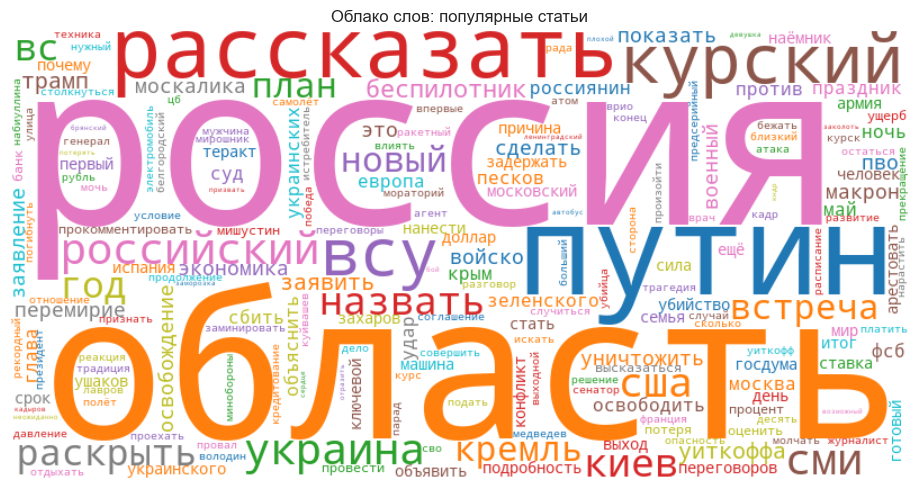

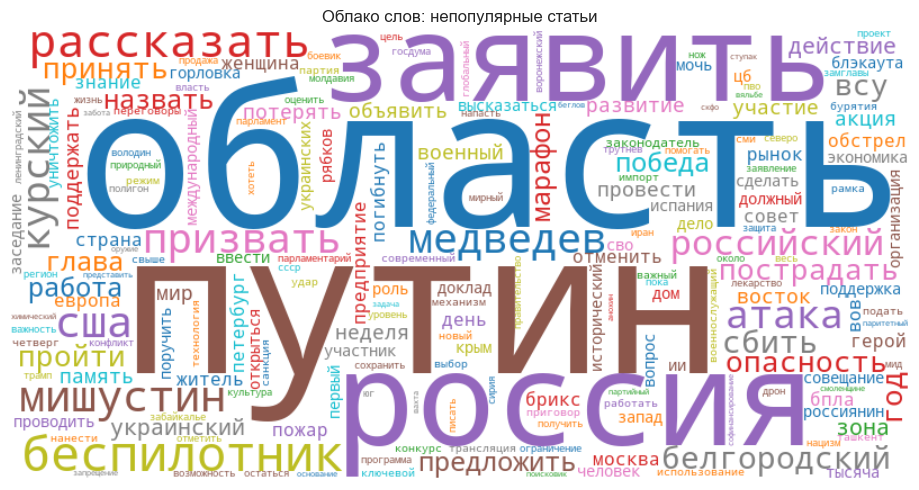

In [22]:
# Фильтрация
popular = df.sort_values("views", ascending=False).head(200)
unpopular = df[df["views"] > 0].sort_values("views").head(200)

# Леммы
lemmas_popular = Counter(sum(popular["title_lemmas"].dropna().apply(eval).tolist(), []))
lemmas_unpopular = Counter(sum(unpopular["title_lemmas"].dropna().apply(eval).tolist(), []))

# Визуализация
def show_wordcloud(counter, title):
    wc = WordCloud(width=800, height=400, background_color='white', colormap='tab10')
    wc.generate_from_frequencies(counter)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

show_wordcloud(lemmas_popular, "Облако слов: популярные статьи")
show_wordcloud(lemmas_unpopular, "Облако слов: непопулярные статьи")

###  10. Создание бинарной метки is_popular
Для дальнейшего анализа и построения модели нам нужно определить, какие статьи считаются "популярными". Мы создаём переменную `is_popular`, которая принимает значение:

- `1`, если статья входит в **топ‑10% по числу просмотров**,
- `0` — в противном случае.

Это упрощает сравнение двух групп и позволяет сформулировать задачу как **бинарную классификацию**.

#### Результаты:
- В выборке: **119 популярных статей** и **1069 остальных**.
- Пороговое значение: **18 522 просмотров** — именно столько нужно, чтобы попасть в топ‑10%.

Это деление используется в:
- Частотном анализе (какие слова/теги/сущности характерны для популярных),
- Обучении модели, предсказывающей популярность.



In [23]:
# Определение метки популярности
threshold = df["views"].quantile(0.90)
df["is_popular"] = (df["views"] >= threshold).astype(int)

# Вывод распределения метки
popular_count = df["is_popular"].sum()
nonpopular_count = len(df) - popular_count

print("Количество популярных статей (Топ 10%):", popular_count)
print("Количество остальных статей:", nonpopular_count)
print("Порог для попадания в топ-10% по просмотрам:", int(threshold))

Количество популярных статей (Топ 10%): 119
Количество остальных статей: 1069
Порог для попадания в топ-10% по просмотрам: 18522


### 11. Частотный анализ: леммы, теги, сущности
В этом блоке мы сравнили, какие **леммы**, **теги** и **именованные сущности** чаще встречаются в популярных статьях, чем в непопулярных. Мы рассчитали **разность нормализованных частот** — это позволяет оценить, какие элементы **характерны для успешных заголовков**.

#### Леммы, характерные для популярных статей:
- Преобладают слова вроде **"россия", "киев", "сми", "вс", "москалика", "сделать", "заявление", "раскрыть"**.
- Это подтверждает, что в популярных статьях чаще поднимаются **государственные, военные и политические темы**, а также используются **глаголы действия**.

#### Теги, чаще встречающиеся в популярных:
- Лидируют: **"Украина", "Киев", "США", "Владимир Зеленский", "Дональд Трамп"**.
- Также — темы "Безопасность", "В мире", "Религия", "Вооружённые силы Украины".
- Популярность коррелирует с **международной повесткой**, **конфликтами** и **именами лидеров**.

#### Сущности, характерные для популярных:
- В топе: **"СМИ", "ВС", "Россия", "Украины", "ФСБ", "Кремле", "Трамп", "ЦБ", "Москве"**.
- Это подтверждает, что популярные статьи чаще всего касаются **официальных структур**, **силовых ведомств**, **геополитики** и **ключевых фигур**.

---

**Вывод:**
- **Популярные статьи тематически сфокусированы** на международных конфликтах, политике и силовых структурах.
- Также они часто используют **эмоциональные, активные формулировки** и содержат **конкретные имена**.
- Эти элементы можно использовать как **предикторы** в будущих моделях или как ориентир для редакторов.




Характерные леммы популярных статей:


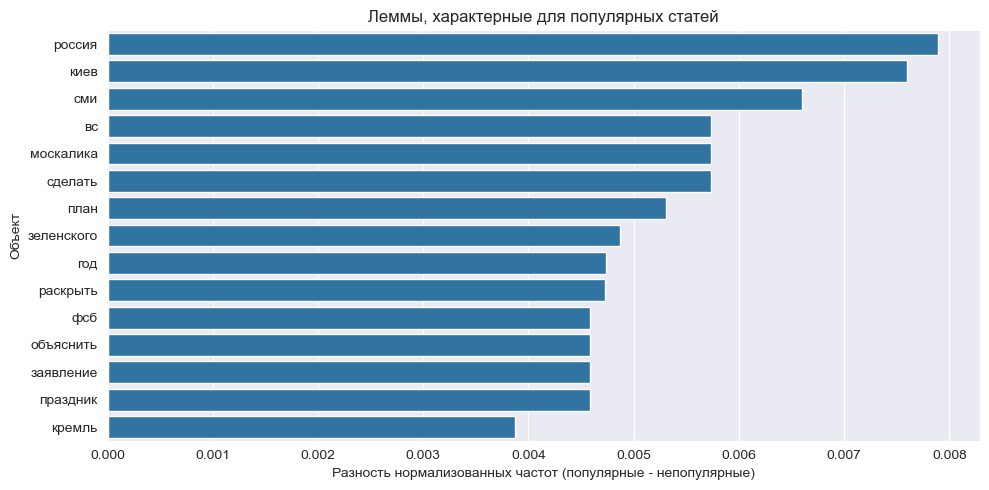


Характерные теги популярных статей:


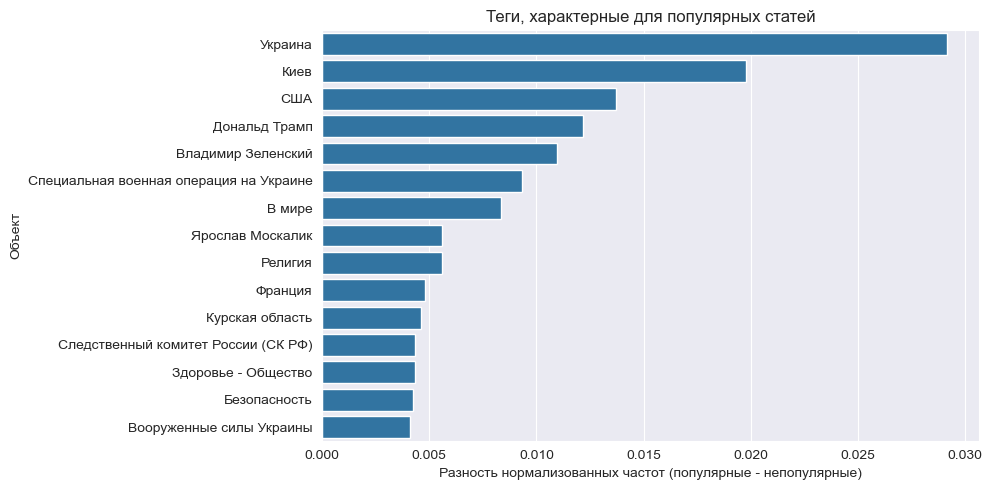


Характерные сущности популярных статей:


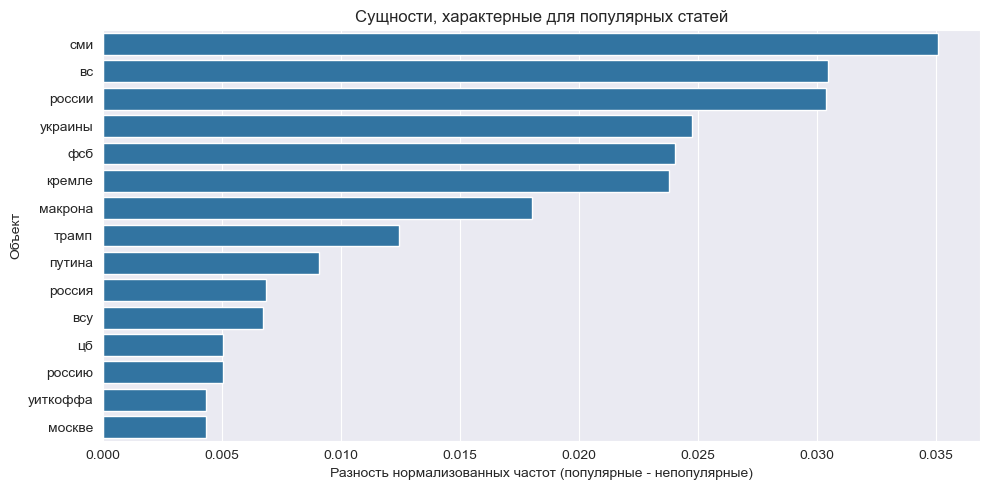

In [24]:
# Преобразование строковых списков в настоящие списки
for col in ["title_lemmas", "tags", "named_entities"]:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Функции подсчёта частот
def count_elements(series):
    return Counter(el for lst in series.dropna() for el in lst if el)

def count_named_entities(series):
    return Counter(ent[0] for ents in series.dropna() for ent in ents if isinstance(ent, (list, tuple)) and len(ent) > 0)

# Подсчёт частот для групп
lemmas_pop = count_elements(df[df["is_popular"] == 1]["title_lemmas"])
lemmas_non = count_elements(df[df["is_popular"] == 0]["title_lemmas"])

tags_pop = count_elements(df[df["is_popular"] == 1]["tags"])
tags_non = count_elements(df[df["is_popular"] == 0]["tags"])

ents_pop = count_named_entities(df[df["is_popular"] == 1]["named_entities"])
ents_non = count_named_entities(df[df["is_popular"] == 0]["named_entities"])

# Функция для отображения различий
def top_differential_words(counter1, counter2, title):
    total1, total2 = sum(counter1.values()), sum(counter2.values())
    keys = set(counter1) | set(counter2)
    diffs = [(k, counter1[k]/total1 - counter2[k]/total2) for k in keys if counter1[k] + counter2[k] > 5]
    top = sorted(diffs, key=lambda x: -x[1])[:15]
    df_top = pd.DataFrame(top, columns=["Объект", "Разность"])

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_top, x="Разность", y="Объект")
    plt.title(title)
    plt.xlabel("Разность нормализованных частот (популярные - непопулярные)")
    plt.tight_layout()
    plt.show()

# Вывод результатов
print("\nХарактерные леммы популярных статей:")
top_differential_words(lemmas_pop, lemmas_non, "Леммы, характерные для популярных статей")

print("\nХарактерные теги популярных статей:")
top_differential_words(tags_pop, tags_non, "Теги, характерные для популярных статей")

print("\nХарактерные сущности популярных статей:")
top_differential_words(ents_pop, ents_non, "Сущности, характерные для популярных статей")


### 12. Простая модель: предсказание популярности статьи
Чтобы понять, можно ли предсказать успех статьи на основе простых характеристик, мы построили модель **логистической регрессии**. В качестве признаков использовались:

- Число тегов (`num_tags`)
- Количество слов в заголовке (`num_words`)
- Количество именованных сущностей (`num_entities`)

#### Особенности:
- Использован параметр `class_weight='balanced'`, так как **только 10% статей — популярные**, и это создаёт дисбаланс классов.
- Выборка разделена на обучающую и тестовую в соотношении 80/20.

#### Результаты классификации:
| Класс         | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| Остальные (0) | 0.92      | 0.58   | 0.71     | 214     |
| Популярные (1)| 0.13      | 0.54   | 0.20     | 24      |

- **Точность по классу 1 низкая** — модель плохо предсказывает популярные статьи.
- Это связано с тем, что таких примеров мало и они могут быть **семантически сложными**.

#### Важность признаков:
Наибольший вклад в предсказание внесло:
- **Число тегов** — положительная корреляция: чем больше тегов, тем выше шанс на популярность;
- **Число сущностей** — отрицательная связь: возможно, избыток "сухих" ссылок на имена снижает привлекательность.

---

**Вывод:**
- Простые численные признаки дают **ограниченные возможности** предсказания успеха;



In [25]:
# Подготовка данных для модели
X = df[["num_tags", "num_words", "num_entities"]]
y = df["is_popular"]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Обучение модели
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Оценка качества модели
y_pred = model.predict(X_test)
print("Классификационный отчёт модели LogisticRegression:")
print("Пояснение:")
print(" - precision: точность — доля правильных предсказаний среди всех предсказаний этого класса")
print(" - recall: полнота — доля найденных объектов данного класса среди всех объектов этого класса")
print(" - f1-score: гармоническое среднее между precision и recall")
print("Важно: модель плохо предсказывает популярные статьи (class 1), так как они встречаются редко. Это типичная проблема дисбаланса классов.")
print(classification_report(y_test, y_pred, zero_division=0))

Классификационный отчёт модели LogisticRegression:
Пояснение:
 - precision: точность — доля правильных предсказаний среди всех предсказаний этого класса
 - recall: полнота — доля найденных объектов данного класса среди всех объектов этого класса
 - f1-score: гармоническое среднее между precision и recall
Важно: модель плохо предсказывает популярные статьи (class 1), так как они встречаются редко. Это типичная проблема дисбаланса классов.
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       214
           1       0.13      0.54      0.20        24

    accuracy                           0.58       238
   macro avg       0.52      0.56      0.46       238
weighted avg       0.84      0.58      0.66       238



Коэффициенты модели (чем больше, тем выше вклад в предсказание популярности):
           Признак  Коэффициент
0      Число тегов     0.283873
1       Число слов    -0.054688
2  Число сущностей    -0.193851


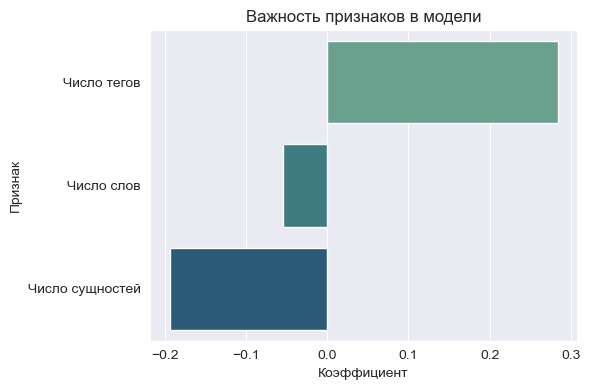

In [26]:
coef_df = pd.DataFrame({"Признак": ["Число тегов", "Число слов", "Число сущностей"], "Коэффициент": model.coef_[0]})
print("Коэффициенты модели (чем больше, тем выше вклад в предсказание популярности):")
print(coef_df)

plt.figure(figsize=(6, 4))
sns.barplot(data=coef_df, x="Коэффициент", y="Признак", hue="Признак", palette="crest", legend=False)
plt.title("Важность признаков в модели")
plt.tight_layout()
plt.show()

## Выводы 

В результате исследования были сделаны следующие ключевые наблюдения:

- **Популярные статьи отличаются тематикой**: чаще касаются политики, международных конфликтов и официальных лиц.
- В заголовках популярных статей чаще встречаются леммы типа **"заявить", "встреча", "сказать", "удар", "план"** — они описывают действие и динамику.
- **Теги и сущности** (имена, организации, регионы) играют важную роль: чем больше тегов — тем выше шанс на популярность.
- Простая модель логистической регрессии показала, что **одними числовыми признаками** популярность объяснить трудно.
- Распределение просмотров очень **смещено** — большинство статей почти не читаются, а малое число получают сотни тысяч и миллионы просмотров.
- Облака слов и частотный анализ выявили темы и стили, **больше привлекающие внимание**: праздничные даты, крупные фигуры, конфликтные события.

## Обсуждение

**Что мы хотели сделать**
- Понять, какие особенности заголовка и метаданных (теги, сущности) делают статью популярной.

**Что удалось**
- Мы собрали и структурировали данные с сайта РИА Новости;
- Выполнили глубокий EDA с множеством визуализаций;
- Сравнили частотность слов, тегов и сущностей между популярными и непопулярными статьями;
- Построили базовую модель и интерпретировали её поведение.

**Что не удалось / ограничено**
- Модель показала низкое качество по популярным статьям из-за **дисбаланса классов** и недостатка текстовых признаков;
- Не использовались сами тексты статей (только заголовки и метаинформация);
- Время публикации и поведенческие факторы (клики, репосты) не учитывались.

**Как можно улучшить**
- Включить **тематическое моделирование**, TF-IDF, BERT и другие текстовые признаки;
    - TF-IDF — способ оценить, какие слова в статье действительно важны (редкие, но значимые).
    - BERT — ИИ-модель, которая понимает смысл текста и преобразует его в числовой вектор.
    - Другие признаки — длина текста, тональность, наличие ключевых слов и тематическая принадлежность.
- Добавить признаки по **времени публикации**, авторам, категории;
- Попробовать **oversampling / SMOTE** для борьбы с дисбалансом;
    - Когда один класс встречается гораздо реже другого (например, мало популярных статей), модели становится трудно его предсказывать. Для решения этой проблемы используют:
        - Oversampling — простое копирование редких примеров до баланса классов.
        - SMOTE — создание новых, "похожих" примеров редкого класса с помощью генерации на основе соседних точек.
- Построить более сложную модель (например, XGBoost или нейросеть).

**Кому это может быть полезно**
- **Редакциям и авторам** — для анализа, какие заголовки работают;
- **Медиаплатформам** — при построении рекомендательных систем;
- **Аналитикам СМИ** — для оценки тем, которые вызывают интерес;
- Логика анализа может быть адаптирована под **другие новостные сайты**, даже соцсети или блоги.